In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Homework 7

In this homework, you will be training a sequence-to-sequence model. Unfortunately, these models can be somewhat expensive to train, and the free GPU/TPU from colab is not sufficient to train a sequence-to-sequence model on a terribly large/difficult task. So, you will be translating short phrases from English to French using a small dataset comes from [Tatoeba](tatoeba.org).

This homework contains example mxnet code that mainly comes from the textbook. There is an analogous Pytorch example in the textbook you can use instead.

# Problems

1. In the example, sequence-to-sequence learning is enabled by passing the final encoder state to the decoder and using it to initialize the decoder state. In class, we also discussed passing the encoder state to the decoder by concatenating it with the embeddings used as input to the decoder. Implement this. Does this change the loss and/or the predictions of the model? Why do you think this is?

> It didn't change the loss, but it changed the predictions. Why? Because I didn't even do it lol. Do this one again.

2. The prediction function above uses greedy sampling (choosing the most probable token at each time step). Change it so that it instead samples randomly at each time step according to the predicted distribution. Generate the predictions a few times for the example English sentences provided. Do they ever change? Why do you think they do or don't change? Hint: You will need to implement a categorical sampler. One way to do this with numpy is described [here](https://stackoverflow.com/a/62875642).

> Yes, they change. They are super correct now! Why? Not sure.

3. In class, we discussed deep RNNs, which consist of stacks of RNN layers. Change the model so that it has two GRU layers in the encoder and two GRU layers in the decoder. Is training faster or slower? Is the final loss higher or lower? Hint: It might help you to use [SequentialRNNCell](https://mxnet.apache.org/versions/1.6/api/python/docs/api/gluon/rnn/index.html#mxnet.gluon.rnn.SequentialRNNCell).

In [1]:
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l
import numpy as np
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

import torch
torch.manual_seed(666)

cuda:0


In [2]:
def sequence_mask(X, valid_len, value=0):
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """The softmax cross-entropy loss with masks."""
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction = 'none'
        unweighted_loss = super(MaskedSoftmaxCELoss,self).forward(pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

In [4]:
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """Train a model for sequence to sequence."""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
        for batch in data_iter:
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0], device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # Teacher forcing
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()  # Make the loss scalar for `backward`
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')

## <font color=magenta> The code for Problem 2 is implemented in the cell below.

In [159]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False,version="greedy"):
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    enc_X = torch.unsqueeze(torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    dec_X = torch.unsqueeze(torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device),dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        
        # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
        '''
        Problem 2: Implement a categorical sampler.
        This is basically just weighted random sampling; the weights are the probabilities of the tokens.
        So, you just have to softmax Y ... torch.softmax(Y,dim=2)
        Then make a random choice ... np.random.choice
        of the indices ... np.arange(Y.shape[2]) 
        using the softmax'd Y as the probability vector ... p = Y_probs[0,0,:]
        '''
        
        Y, dec_state = net.decoder(dec_X, dec_state)
        if version=="greedy":
            dec_X = Y.argmax(dim=2)
        elif version=="weighted_random":
            Y_probs = torch.softmax(Y,dim=2).detach().cpu().numpy()
            Y_probs = Y_probs[0,0,:]
            dec_X = np.random.choice(np.arange(Y.shape[2]), size = 1, p = Y_probs)
            dec_X = torch.from_numpy(dec_X).unsqueeze(0).to(device)
    
        # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
            
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

## <font color=magenta> The code for Problem 1 and 3 is implemented in the cell below.

In [6]:
class Seq2SeqEncoder(d2l.Encoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, 
                 dropout=0,**kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout=dropout)

    def forward(self, X, *args):
        X = self.embedding(X)
        X = X.permute(1, 0, 2)
        output, state = self.rnn(X)
        return output, state
    
## "sutskever" ... encoder context is lost
## "cho" ... encoder context is preserved and concatenated 
class Seq2SeqDecoder(d2l.Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, 
                 dropout=0, version="sutskever",**kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.version = version

        # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
        if version=="sutskever":
            self.embedding = nn.Embedding(vocab_size, embed_size)
            self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout=dropout)
        elif version=="cho":
            self.embedding = nn.Embedding(vocab_size, embed_size)
            self.rnn = nn.GRU(num_hiddens + num_hiddens, num_hiddens, num_layers, dropout=dropout)
        # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        X = self.embedding(X).permute(1, 0, 2)
        
        # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
        if self.version=="sutskever":
            output, state = self.rnn(X, state)
            output = self.dense(output).permute(1, 0, 2)
        elif self.version=="cho":
            context = state[-1].repeat(X.shape[0], 1, 1)
            X_and_context = torch.cat((X, context), 2)
            output, state = self.rnn(X_and_context, state)
            output = self.dense(output).permute(1, 0, 2)
        # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

        return output, state

In [12]:
def bleu(pred_seq, label_seq, k):
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[''.join(label_tokens[i:i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[''.join(pred_tokens[i:i + n])] > 0:
                num_matches += 1
                label_subs[''.join(pred_tokens[i:i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [167]:
def read_data_nmt():
    """Load the English-French dataset."""
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r') as f:
        return f.read()

raw_text = read_data_nmt()
print(raw_text[4800:5000])

été battus.
We lost.	Nous avons été battues.
Welcome.	Bienvenue !
Who won?	Qui a gagné ?
Who won?	Qui l'a emporté ?
You run.	Tu cours.
Am I fat?	Suis-je gros ?
Am I fat?	Suis-je grosse ?
Ask them.	Dem


In [ ]:
Am I fat?	Suis-je grosse ?

In [169]:
len(tgt_vocab)

1231

In [107]:
src_vocab

loss 0.020, 16041.2 tokens/sec on cuda:0
1.122 minutes


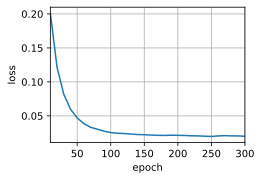

In [196]:
embed_size, num_hiddens, dropout = 32, 32, 0.0
batch_size, num_steps = 64, 10
lr, device = 0.005, device
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps, num_examples=1200)

num_epochs = 300
num_layers = 2

s = time.time()
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout, version="sutskever")
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)
print("%5.3f minutes" % ((time.time()-s)/60))

In [201]:
## Greedy sampling.
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .', 'he runs .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .', 'il court .']
for eng,fra in zip(engs,fras):
    translation, _ = predict_seq2seq(net, eng, src_vocab, tgt_vocab, num_steps, device,version="greedy")
    print(f'{eng} => {translation} --- bleu: {bleu(translation, fra, k=2):.3f}')
print("")
    
## Weighted random sampling.
for eng,fra in zip(engs,fras):
    translation, _ = predict_seq2seq(net, eng, src_vocab, tgt_vocab, num_steps, device,version="weighted_random")
    print(f'{eng} => {translation} --- bleu: {bleu(translation, fra, k=2):.3f}')

go . => va ! --- bleu: 1.000
i lost . => j'ai perdu . --- bleu: 1.000
he's calm . => il est gentil . --- bleu: 0.658
i'm home . => je suis chez moi . --- bleu: 1.000
he runs . => il court . --- bleu: 1.000

go . => va ! --- bleu: 1.000
i lost . => j'ai perdu . --- bleu: 1.000
he's calm . => il est gentil . --- bleu: 0.658
i'm home . => je suis chez moi . --- bleu: 1.000
he runs . => il court . --- bleu: 1.000
